# Proyecto Reconocimiento Facial - IIC3724
## Grupo 14

---

Felipe Domínguez - 1562188J

Sebastián Carreño - 15639746

Diego Iruretagoyena - 14619164

## Setup

In [1]:
from platform import python_version

print(python_version())

3.7.6


In [2]:
import cv2
import os
import numpy as np
import pandas as pd

from datetime import datetime
from collections import defaultdict

from pybalu.io import imread
from pybalu.feature_selection import clean, sfs
from pybalu.feature_transformation import normalize, pca
from pybalu.feature_extraction import haralick_features, lbp_features, gabor_features, hog_features, basic_int_features, fourier_features, gupta_features, flusser_features

from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD, Adam
from keras.layers import Dense
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import CSVLogger, Callback

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.style.use('ggplot')

Using TensorFlow backend.


In [3]:
DATASET_PATH = 'FaceMask166'
FEATURES_PATH = 'features'
NUM_OF_CLASSES = 166

## Utils

In [4]:
def open_image(image_path):
    image = cv2.imread(f'{DATASET_PATH}/{image_path}')
    return image

def extract_lbp(image, hdiv, vdiv, grayscale=True, mapping='nri_uniform', channel=None):
    """
    Interface for pybalu implementation
    """

    if grayscale:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif channel != None:
        lbp_features(image[:, :, channel], hdiv=hdiv, vdiv=vdiv, mapping=mapping)

    return lbp_features(image, hdiv=hdiv, vdiv=vdiv, mapping=mapping)

def extract_features(images):
    """
    Returns a hash with all features extracted
    """

    features = defaultdict(list)
    
    for i, image in enumerate(images):
        print(f'Processing image {i}...')

        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        features['intensity'].append(basic_int_features(grayscale_image))
        features['fourier'].append(fourier_features(grayscale_image))
        features['haralick'].append(haralick_features(grayscale_image))
        features['gabor'].append(gabor_features(grayscale_image))
        features['hog_1_1_4'].append(hog_features(grayscale_image, v_windows=1, h_windows=1, n_bins=4))
        features['hog_5_5_8'].append(hog_features(grayscale_image, v_windows=5, h_windows=5, n_bins=8))

        features['lbp_bw_1_1'].append(extract_lbp(image, 1, 1))
        features['lbp_bw_2_2'].append(extract_lbp(image, 2, 2))
        features['lbp_bw_4_8'].append(extract_lbp(image, 4, 8))
        features['lbp_bw_8_4'].append(extract_lbp(image, 8, 4))

        features['lbp_red_8_4'].append(extract_lbp(image, 8, 4, channel=0))
        features['lbp_green_8_4'].append(extract_lbp(image, 8, 4, channel=1))
        features['lbp_blue_8_4'].append(extract_lbp(image, 8, 4, channel=2))

    for key in features.keys():
        features[key] = np.array(features[key])

    return features

def nn_clasiffier(options):
    input_dim = options['input_dim']
    d1 = options['d1']
    d2 = options['d2']
    opt = options['opt']

    model = Sequential()
    model.add(Dense(d1, input_dim=input_dim, init='uniform', activation='relu'))
    model.add(Dense(d2, activation='relu', kernel_initializer='uniform'))
    model.add(Dense(options['n_clases']))
    model.add(Activation('softmax'))

    if opt == 'adam':
        optimizer = Adam()
    elif opt == 'sgd':
        optimizer = SGD()

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

def get_classifier(classifier, options=None):
    """
    Returns desired clasiffier
    """

    if classifier == 'knn':
        return KNeighborsClassifier(n_neighbors=3)
    elif classifier == 'svm':
        return SVC(kernel='sigmoid', gamma='auto', C=1)
    elif classifier == 'linear_svm':
        return LinearSVC()
    elif classifier == 'ada':
        return AdaBoostClassifier(n_estimators=100)
    elif classifier == 'nn':
        return nn_clasiffier(options)

def normalize_each_class(train_features, val_features, test_features):
    """
    input_features: hash where each key contains a np.array with extracted features

    It normalizes each class in train_features, and then normalizes test_features using a,b values from train examples.
    """
    
    train_features_norm = {}
    val_features_norm = {}
    test_features_norm = {}

    for key in train_features.keys():
        train_norm, a, b = normalize(train_features[key])
        val_norm = val_features[key] * a + b
        test_norm = test_features[key] * a + b
        
        train_features_norm[key] = train_norm
        val_features_norm[key] = val_norm
        test_features_norm[key] = test_norm
        
    return train_features_norm, val_features_norm, test_features_norm

def plot_nn_csv(file_name):
    """
    Plots neural model from csv file saved in callbacks
    """

    file = pd.read_csv(file_name)

    (fig, axs) = plt.subplots(2, 1, figsize=(10, 10))

    axs[0].plot(file['epoch'], file['loss'])
    axs[0].set_title('Loss by epoch')
    axs[0].set_xlabel('Epoch #')
    axs[0].set_ylabel('Loss')

    axs[1].plot(file['epoch'], file['accuracy'])
    axs[1].set_title('Train accuracy')
    axs[1].set_xlabel('Epoch #')
    axs[1].set_ylabel('Accuracy')

    plt.tight_layout()

    plt.savefig(f"{file_name.split('.csv')[0]}.png")
    plt.show()

def plot_images(image_1, image_2):
    (fig, axs) = plt.subplots(1, 2, figsize=(15, 15))
    axs[0].imshow(image_1)
    axs[1].imshow(image_2)

    plt.tight_layout()
    plt.show()

def concat_features(features_hash):
    """
    Return a np.array with all features concatenated
    """

    return np.concatenate(list(features_hash.values()), axis=1)

def save_features(features, path):
    for key in features.keys():
        features_df = pd.DataFrame(data=features[key])
        features_df.to_csv(f'{path}/{key}.csv', header=True, index=False)

def load_features(path):
    features = {}

    for file_name in os.listdir(path):
        if file_name.endswith('csv'):
            feature_name = file_name.split('.')[0]
            features[feature_name] = pd.read_csv(f'{path}/{file_name}').to_numpy()

    return features


## Load Data

Para simplificar algunas cosas, el suefo F000166 lo renombramos a F000000 en la base de datos

In [5]:
images_names = sorted([file_name for file_name in os.listdir(DATASET_PATH) if file_name.endswith('jpg')])
images_names = images_names[:(NUM_OF_CLASSES * 6)]
print(images_names[-1])

FM000165_06.jpg


In [6]:
TRAIN_NAMES = sorted([i for i in images_names if (i.endswith('01.jpg') or i.endswith('02.jpg') or i.endswith('03.jpg'))])
VALIDATION_NAMES = sorted([i for i in images_names if i.endswith('04.jpg')])
TEST_NAMES = sorted([i for i in images_names if (i.endswith('05.jpg') or i.endswith('06.jpg'))])

Y_TRAIN = np.array([int(image_name.split('_')[0][2:]) for image_name in TRAIN_NAMES]).astype(int)
Y_VAL = np.array([int(image_name.split('_')[0][2:]) for image_name in VALIDATION_NAMES]).astype(int)
Y_TEST = np.array([int(image_name.split('_')[0][2:]) for image_name in TEST_NAMES]).astype(int)

print(Y_TRAIN[-1])

TRAIN_IMAGES = [open_image(image_path)[:95,35:-35] for image_path in TRAIN_NAMES]
VAL_IMAGES = [open_image(image_path)[:95,35:-35] for image_path in VALIDATION_NAMES]
TEST_IMAGES = [open_image(image_path)[:95,35:-35] for image_path in TEST_NAMES]

def build_dataset(n_clases):
    train_limit = n_clases * 3
    val_limit = n_clases
    test_limit = n_clases * 2

    dataset = {}
    dataset['n_clases'] = n_clases
    dataset['train_limit'] = train_limit
    dataset['val_limit'] = val_limit
    dataset['test_limit'] = test_limit
    dataset['y_train'] = Y_TRAIN[:train_limit]
    dataset['y_val'] = Y_VAL[:val_limit]
    dataset['y_test'] = Y_TEST[:test_limit]
    dataset['train_images'] = TRAIN_IMAGES[:train_limit]
    dataset['val_images'] = VAL_IMAGES[:val_limit]
    dataset['test_images'] = TEST_IMAGES[:test_limit]
    dataset['x_train'] = []
    dataset['x_val'] = []
    dataset['x_test'] = []

    return dataset

165


In [7]:
# Definir los distintos conjuntos
datasets = {}
datasets['dataset_16'] = build_dataset(16)
datasets['dataset_40'] = build_dataset(40)
datasets['dataset_100'] = build_dataset(100)
datasets['dataset_166'] = build_dataset(166)

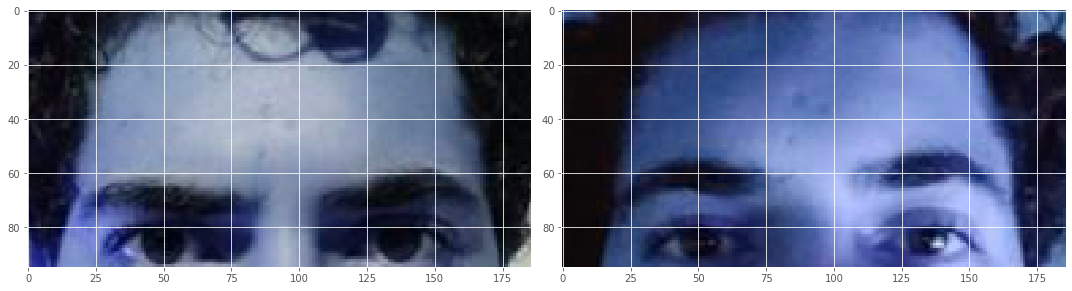

In [8]:
plot_images(TRAIN_IMAGES[0], TEST_IMAGES[0])

## Get Features

In [9]:
LOAD = False

if LOAD:
    # Option 1: read features from csv files
    features_train_hash = load_features(f'{FEATURES_PATH}/train')
    features_val_hash = load_features(f'{FEATURES_PATH}/val')
    features_test_hash = load_features(f'{FEATURES_PATH}/test')

else:
    # Option 2: extract features
    features_train_hash = extract_features(TRAIN_IMAGES)
    features_val_hash = extract_features(VAL_IMAGES)
    features_test_hash = extract_features(TEST_IMAGES)

    save_features(features_train_hash, path=f'{FEATURES_PATH}/train')
    save_features(features_val_hash, path=f'{FEATURES_PATH}/val')
    save_features(features_test_hash, path=f'{FEATURES_PATH}/test')

Processing image 0...
Processing image 1...
Processing image 2...
Processing image 3...
Processing image 4...
Processing image 5...
Processing image 6...
Processing image 7...
Processing image 8...
Processing image 9...
Processing image 10...
Processing image 11...
Processing image 12...
Processing image 13...
Processing image 14...
Processing image 15...
Processing image 16...
Processing image 17...
Processing image 18...
Processing image 19...
Processing image 20...
Processing image 21...
Processing image 22...
Processing image 23...
Processing image 24...
Processing image 25...
Processing image 26...
Processing image 27...
Processing image 28...
Processing image 29...
Processing image 30...
Processing image 31...
Processing image 32...
Processing image 33...
Processing image 34...
Processing image 35...
Processing image 36...
Processing image 37...
Processing image 38...
Processing image 39...
Processing image 40...
Processing image 41...
Processing image 42...
Processing image 43..

Processing image 346...
Processing image 347...
Processing image 348...
Processing image 349...
Processing image 350...
Processing image 351...
Processing image 352...
Processing image 353...
Processing image 354...
Processing image 355...
Processing image 356...
Processing image 357...
Processing image 358...
Processing image 359...
Processing image 360...
Processing image 361...
Processing image 362...
Processing image 363...
Processing image 364...
Processing image 365...
Processing image 366...
Processing image 367...
Processing image 368...
Processing image 369...
Processing image 370...
Processing image 371...
Processing image 372...
Processing image 373...
Processing image 374...
Processing image 375...
Processing image 376...
Processing image 377...
Processing image 378...
Processing image 379...
Processing image 380...
Processing image 381...
Processing image 382...
Processing image 383...
Processing image 384...
Processing image 385...
Processing image 386...
Processing image

Processing image 30...
Processing image 31...
Processing image 32...
Processing image 33...
Processing image 34...
Processing image 35...
Processing image 36...
Processing image 37...
Processing image 38...
Processing image 39...
Processing image 40...
Processing image 41...
Processing image 42...
Processing image 43...
Processing image 44...
Processing image 45...
Processing image 46...
Processing image 47...
Processing image 48...
Processing image 49...
Processing image 50...
Processing image 51...
Processing image 52...
Processing image 53...
Processing image 54...
Processing image 55...
Processing image 56...
Processing image 57...
Processing image 58...
Processing image 59...
Processing image 60...
Processing image 61...
Processing image 62...
Processing image 63...
Processing image 64...
Processing image 65...
Processing image 66...
Processing image 67...
Processing image 68...
Processing image 69...
Processing image 70...
Processing image 71...
Processing image 72...
Processing 

## Preprocessing

In [10]:
# TODO: Preguntar al profe

# NORMALIZE
train_features_norm, val_features_norm, test_features_norm = normalize_each_class(
    features_train_hash, 
    features_val_hash, 
    features_test_hash
)

/opt/anaconda3/lib/python3.7/site-packages/pybalu/feature_transformation/normalize.py:6: RuntimeWarning: divide by zero encountered in true_divide
  a = 1 / sf
/opt/anaconda3/lib/python3.7/site-packages/pybalu/feature_transformation/normalize.py:7: RuntimeWarning: divide by zero encountered in true_divide
  b = - mf / sf
/opt/anaconda3/lib/python3.7/site-packages/pybalu/feature_transformation/normalize.py:8: RuntimeWarning: invalid value encountered in add
  return X * a + b, a, b
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in add
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in add


In [11]:
features_train_concat = concat_features(train_features_norm)
features_val_concat = concat_features(val_features_norm)
features_test_concat = concat_features(test_features_norm)

print(features_train_concat.shape)
print(features_val_concat.shape)
print(features_test_concat.shape)

(498, 10048)
(166, 10048)
(332, 10048)


In [12]:
# CLEAN
clean_indexes = clean(features_train_concat)

train_features_cleaned = features_train_concat[:, clean_indexes]
val_features_cleaned = features_val_concat[:, clean_indexes]
test_features_cleaned = features_test_concat[:, clean_indexes]

# train_features_cleaned = features_train_concat[:, :100]
# val_features_cleaned = features_val_concat[:, :100]
# test_features_cleaned = features_test_concat[:, :100]

print(train_features_cleaned.shape)
print(val_features_cleaned.shape)
print(test_features_cleaned.shape)

(498, 4349)
(166, 4349)
(332, 4349)


In [13]:
TRAIN_FEATURES_CONCAT = np.nan_to_num(train_features_cleaned).astype(float)
VAL_FEATURES_CONCAT = np.nan_to_num(val_features_cleaned).astype(float)
TEST_FEATURES_CONCAT = np.nan_to_num(test_features_cleaned).astype(float)

In [14]:
def add_features_to_dataset(datasets):
    for key in datasets.keys():
        datasets[key]['x_train'] = TRAIN_FEATURES_CONCAT[:datasets[key]['train_limit']]
        datasets[key]['x_val'] = VAL_FEATURES_CONCAT[:datasets[key]['val_limit']]
        datasets[key]['x_test'] = TEST_FEATURES_CONCAT[:datasets[key]['test_limit']]

    return datasets

datasets = add_features_to_dataset(datasets)

In [15]:
LOAD_SFS = False
SFS_ALL = {}
N_SFS_FEATURES = [50]

if LOAD_SFS:
    for key in datasets.keys():
        sfs_hash = load_features(f'sfs/{key}')
        for sfs_key in sfs_hash:
            sfs_hash[sfs_key] = sfs_hash[sfs_key].flatten()
        SFS_ALL[key] = sfs_hash

else:
    for key in datasets.keys():
        sfs_hash = {}
        for n_sfs in N_SFS_FEATURES:
            sfs_indexes = sfs(datasets[key]['x_train'], datasets[key]['y_train'], n_features=n_sfs, method='fisher', show=True)
            sfs_hash[f'{n_sfs}'] = np.array([sfs_indexes])

        save_features(sfs_hash, path=f'sfs/{key}')
        SFS_ALL[key] = sfs_hash

Selecting Features: 100%|██████████| 50.0/50.0 [05:24<00:00, 7.40s/ features]
Selecting Features: 100%|██████████| 50.0/50.0 [11:54<00:00, 17.8s/ features]
Selecting Features: 100%|██████████| 50.0/50.0 [28:07<00:00, 43.1s/ features]
Selecting Features: 100%|██████████| 50.0/50.0 [49:27<00:00, 71.9s/ features]


In [17]:
LOAD_PCA = False
PCA_ALL = {}
n_features_to_extract = [100, 200, 300]
# n_features_to_extract = [20, 50]

if LOAD_PCA:
    for key in datasets.keys():
        PCA_ALL[key] = {}
        for n_pca in n_features_to_extract:
            pca_hash = load_features(f'pca/{key}/{n_pca}')
            PCA_ALL[key][f'{n_pca}'] = pca_hash

else:
    for key in datasets.keys():
        pca_hash = {}
        for n_pca in n_features_to_extract:
            pca_train, _, A, Xm, _ = pca(datasets[key]['x_train'], n_components=n_pca)
            pca_val = np.matmul(datasets[key]['x_val'] - Xm, A)
            pca_test = np.matmul(datasets[key]['x_test'] - Xm, A)

            pca_hash[f'{n_pca}'] = {
                'train': pca_train,
                'val': pca_val,
                'test': pca_test,
            }

            save_features(pca_hash[f'{n_pca}'], path=f'pca/{key}/{n_pca}')

        PCA_ALL[key] = pca_hash

#print(PCA_ALL['dataset_16']['20']['train'].shape)

# Estrategias

Cabe destacar que como preprocesamiento de cada estrategia se hace un normalizado y luego un clean. De esta manera se evita repetir código.
De todas formas ambos pasos fueron nombrados en cada estrategia.

## Dataset 1: 16 clases

In [118]:
DATASET_NAME = "dataset_16"
DATASET_16 = datasets[DATASET_NAME]

for i in datasets:
    print(i)

dataset_16
dataset_40
dataset_100
dataset_166


In [119]:
# PCA100
train_pca_100 = PCA_ALL[DATASET_NAME]['100']['train']
val_pca_100 = PCA_ALL[DATASET_NAME]['100']['val']
test_pca_100 = PCA_ALL[DATASET_NAME]['100']['test']

# PCA300
train_pca_300 = PCA_ALL[DATASET_NAME]['300']['train']
val_pca_300 = PCA_ALL[DATASET_NAME]['300']['val']
test_pca_300 = PCA_ALL[DATASET_NAME]['300']['test']

In [120]:
# PCA300 -> SFS15
sfs_indexes = sfs(train_pca_300, DATASET_16['y_train'], n_features=15, method='fisher', show=True)

train_pca_300_sfs_15 = train_pca_300[:, sfs_indexes]
val_pca_300_sfs_15 = val_pca_300[:, sfs_indexes]
test_pca_300_sfs_15 = test_pca_300[:, sfs_indexes]

Selecting Features: 100%|██████████| 15.0/15.0 [00:05<00:00, 2.91 features/s]


In [121]:
# sfs_indexes = sfs(train_pca_300, DATASET_16['y_train'], n_features=15, method='fisher', show=True)

print(train_pca_300[:, sfs_indexes].shape)
print(sfs_indexes)

(48, 15)
[  6   1   3  97 169 106 242 273 276 217 127 194 153   9 280]


## Estrategia 1

    NORM - CLEAN - SFS15 - KNN3

In [122]:
def estrategy_1(sfs_train, sfs_val, sfs_test, classifier, print_conf_matrix=False):
    classifier = get_classifier(classifier)
    classifier.fit(sfs_train, DATASET_16['y_train'])

    train_pred = classifier.predict(sfs_train)
    val_pred = classifier.predict(sfs_val)
    test_pred = classifier.predict(sfs_test)

    train_accuracy = accuracy_score(DATASET_16['y_train'], train_pred) * 100
    val_accuracy = accuracy_score(DATASET_16['y_val'], val_pred) * 100
    test_accuracy = accuracy_score(DATASET_16['y_test'], test_pred) * 100

    print(f'\nTrain Accuracy: {train_accuracy}')
    print(f'Val Accuracy: {val_accuracy}')
    print(f'Test Accuracy: {test_accuracy}\n')

    if print_conf_matrix:
        conf_matrix = confusion_matrix(DATASET_16['y_test'], test_pred)
        print(conf_matrix)

In [123]:
N_SFS_FEATURES = [50]

In [124]:
# KNN 3

DATASET_16 = datasets[DATASET_NAME]

sfs_indexes = SFS_ALL[DATASET_NAME]["50"][0]

x_train = datasets[DATASET_NAME]['x_train'][:, sfs_indexes]
x_val = datasets[DATASET_NAME]['x_val'][:, sfs_indexes]
x_test = datasets[DATASET_NAME]['x_test'][:, sfs_indexes]

print(f'------- SFS  50 -------')
estrategy_1(x_train, x_val, x_test, 'knn')

------- SFS  50 -------

Train Accuracy: 66.66666666666666
Val Accuracy: 18.75
Test Accuracy: 34.375



### Estrategia 1.2

    NORM - CLEAN - SFS15 - ADA

In [125]:
for n_sfs in N_SFS_FEATURES:
    sfs_indexes = SFS_ALL[DATASET_NAME][f'{n_sfs}'][0]

    x_train = datasets[DATASET_NAME]['x_train'][:, sfs_indexes]
    x_val = datasets[DATASET_NAME]['x_val'][:, sfs_indexes]
    x_test = datasets[DATASET_NAME]['x_test'][:, sfs_indexes]

    print(f'------- SFS {n_sfs} -------')
    estrategy_1(x_train, x_val, x_test, 'ada')

------- SFS 50 -------

Train Accuracy: 25.0
Val Accuracy: 12.5
Test Accuracy: 9.375



### Estrategia 1.3

    NORM - CLEAN - SFS15 - SVM(sigmoid)

In [126]:
for n_sfs in N_SFS_FEATURES:
    sfs_indexes = SFS_ALL[DATASET_NAME][f'{n_sfs}'][0]

    x_train = datasets[DATASET_NAME]['x_train'][:, sfs_indexes]
    x_val = datasets[DATASET_NAME]['x_val'][:, sfs_indexes]
    x_test = datasets[DATASET_NAME]['x_test'][:, sfs_indexes]

    print(f'------- SFS {n_sfs} -------')
    estrategy_1(x_train, x_val, x_test, 'svm')

------- SFS 50 -------

Train Accuracy: 97.91666666666666
Val Accuracy: 50.0
Test Accuracy: 62.5



### Estrategia 1.4

    NORM - CLEAN - SFS15 - LinearSVM

## Estrategia 2

    NORM - CLEAN - PCA100 - KNN3

In [127]:
# KNN 3
classifier = get_classifier('knn')
classifier.fit(train_pca_100, DATASET_16['y_train'])

train_pred = classifier.predict(train_pca_100)
val_pred = classifier.predict(val_pca_100)
test_pred = classifier.predict(test_pca_100)

train_accuracy = accuracy_score(DATASET_16['y_train'], train_pred) * 100
val_accuracy = accuracy_score(DATASET_16['y_val'], val_pred) * 100
test_accuracy = accuracy_score(DATASET_16['y_test'], test_pred) * 100

conf_matrix = confusion_matrix(DATASET_16['y_val'], val_pred)

print(f'\nTrain Accuracy: {train_accuracy}')
print(f'Val Accuracy: {val_accuracy}')
print(f'Test Accuracy: {test_accuracy}\n')

print(conf_matrix)


Train Accuracy: 75.0
Val Accuracy: 56.25
Test Accuracy: 46.875

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


## Estrategia 3

    NORM - CLEAN - PCA300 - SFS15 - KNN3

In [128]:
# KNN 3
classifier = get_classifier('knn')
classifier.fit(train_pca_300_sfs_15, DATASET_16['y_train'])

train_pred = classifier.predict(train_pca_300_sfs_15)
test_pred = classifier.predict(val_pca_300_sfs_15)

train_accuracy = accuracy_score(DATASET_16['y_train'], train_pred) * 100
val_accuracy = accuracy_score(DATASET_16['y_val'], val_pred) * 100

conf_matrix = confusion_matrix(DATASET_16['y_val'], val_pred)

print(f'\nTrain Accuracy: {train_accuracy}')
print(f'Val Accuracy: {val_accuracy}\n')

print(conf_matrix)


Train Accuracy: 66.66666666666666
Val Accuracy: 56.25

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


### Estrategia 3.1

    NORM - CLEAN - PCA300 - SFS15 - NN

In [129]:
# NN with 2 hidden layers
feat_dimension = train_pca_300_sfs_15[0].shape[0]
model = get_classifier('nn', options={'input_dim': feat_dimension, 'd1': 5, 'd2': 5, 'opt': 'adam', 'n_clases': DATASET_16['n_clases']})

# Labels to one-hot encoding
categorical_train = np_utils.to_categorical(DATASET_16['y_train'], num_classes=DATASET_16['n_clases'])
categorical_val = np_utils.to_categorical(DATASET_16['y_val'], num_classes=DATASET_16['n_clases'])
categorical_test = np_utils.to_categorical(DATASET_16['y_test'], num_classes=DATASET_16['n_clases'])

# NN callbacks
csv_logger = CSVLogger('plots/nn_1_est3.csv', separator=',', append=False)
early_stop = EarlyStopping(monitor='val_loss', patience=2)
callbacks = [csv_logger, early_stop]

start = datetime.now()

# TODO: use validation set to keep best model
model.fit(train_pca_300_sfs_15, categorical_train, epochs=50, batch_size=1, verbose=1, callbacks=callbacks)

run_time = datetime.now() - start
print('Train time: ', run_time)

(loss, val_accuracy) = model.evaluate(val_pca_300_sfs_15, categorical_val, batch_size=4, verbose=1)
(loss, test_accuracy) = model.evaluate(test_pca_300_sfs_15, categorical_test, batch_size=4, verbose=1)

print('\nVal Accuracy: ', val_accuracy * 100)
print('Test Accuracy: ', test_accuracy * 100)

Epoch 1/50
48/48 [==============================] - 1s 31ms/step - loss: 0.2341 - accuracy: 0.9375
Epoch 2/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2335 - accuracy: 0.9375
Epoch 3/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2329 - accuracy: 0.9375
Epoch 4/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2319 - accuracy: 0.9375
Epoch 5/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2304 - accuracy: 0.9375
Epoch 6/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2275 - accuracy: 0.9375
Epoch 7/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2238 - accuracy: 0.9375
Epoch 8/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2181 - accuracy: 0.9375
Epoch 9/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2121 - accuracy: 0.9375
Epoch 10/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2054 - accuracy: 0.9375
Epoch 11/50
48/48 

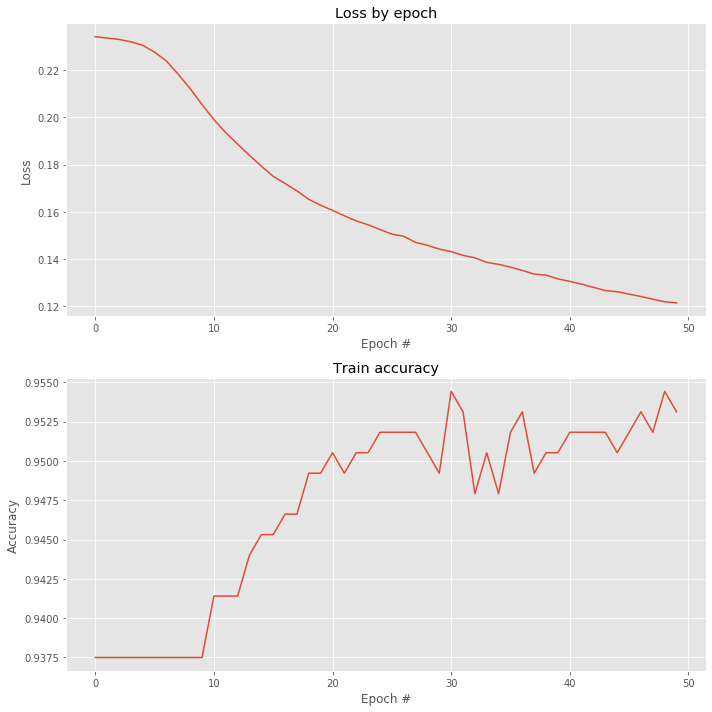

In [130]:
plot_nn_csv('plots/nn_1_est3.csv')

## Estrategia 4

                        - PCA50 - 
      NORM - CLEAN  |              | - SFS15 - NN
                        - SFS50 - 


In [131]:
# BRANCH 1: PCA50
branch_1_train = PCA_ALL[DATASET_NAME]['50']['train']
branch_1_val = PCA_ALL[DATASET_NAME]['50']['val']
branch_1_test = PCA_ALL[DATASET_NAME]['50']['test']

# BRANCH 2: SFS50
sfs_indexes = SFS_ALL[DATASET_NAME]['50']

branch_2_train = DATASET_16['x_train'][:, sfs_indexes]
branch_2_val = DATASET_16['x_val'][:, sfs_indexes]
branch_2_test = DATASET_16['x_test'][:, sfs_indexes]

# Concat branches
concat_train = np.concatenate((branch_1_train, branch_2_train), axis=1)
concat_val = np.concatenate((branch_1_val, branch_2_val), axis=1)
concat_test = np.concatenate((branch_1_test, branch_2_test), axis=1)

# SFS15
sfs_indexes = sfs(concat_train, DATASET_16['y_train'], n_features=15, method='fisher', show=True)

x_train = concat_train[:, sfs_indexes]
x_val = concat_val[:, sfs_indexes]
x_test = concat_test[:, sfs_indexes]

KeyError: '50'

In [132]:
# NN with 2 hidden layers
feat_dimension = x_train[0].shape[0]
model = get_classifier('nn', options={'input_dim': feat_dimension, 'd1': 30, 'd2': 15, 'opt': 'adam', 'n_clases': DATASET_16['n_clases']})

# Labels to one-hot encoding
categorical_train = np_utils.to_categorical(DATASET_16['y_train'], num_classes=DATASET_16['n_clases'])
categorical_val = np_utils.to_categorical(DATASET_16['y_val'], num_classes=DATASET_16['n_clases'])
categorical_test = np_utils.to_categorical(DATASET_16['y_test'], num_classes=DATASET_16['n_clases'])

# NN callbacks
csv_logger = CSVLogger('plots/nn_1_est4.csv', separator=',', append=False)
early_stop = EarlyStopping(monitor='val_loss', patience=2)
callbacks = [csv_logger, early_stop]

start = datetime.now()

# TODO: use validation set to keep best model
model.fit(x_train, categorical_train, epochs=50, batch_size=1, verbose=1, callbacks=callbacks)

run_time = datetime.now() - start
print('Train time: ', run_time)

(loss, val_accuracy) = model.evaluate(x_val, categorical_val, batch_size=1, verbose=1)
(loss, test_accuracy) = model.evaluate(x_test, categorical_test, batch_size=1, verbose=1)

print('\nVal Accuracy: ', val_accuracy * 100)
print('Test Accuracy: ', test_accuracy * 100)

Epoch 1/50
48/48 [==============================] - 1s 21ms/step - loss: 0.2342 - accuracy: 0.9375
Epoch 2/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2322 - accuracy: 0.9375
Epoch 3/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2299 - accuracy: 0.9375
Epoch 4/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2251 - accuracy: 0.9375
Epoch 5/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2165 - accuracy: 0.9375
Epoch 6/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2030 - accuracy: 0.9375
Epoch 7/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1859 - accuracy: 0.9375
Epoch 8/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1645 - accuracy: 0.9388
Epoch 9/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1430 - accuracy: 0.9453
Epoch 10/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1208 - accuracy: 0.9505
Epoch 11/50
48/48 

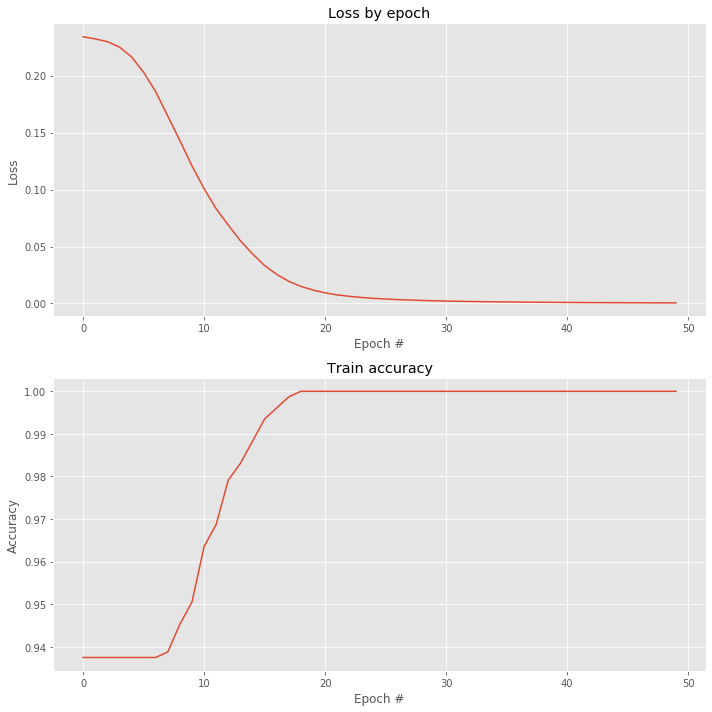

In [133]:
plot_nn_csv('plots/nn_1_est4.csv')

## Estrategia 5

In [134]:
def estrategy_5(feat_train, feat_val, feat_test, classifier, print_conf_matrix=False):
    classifier = get_classifier(classifier)
    classifier.fit(feat_train, DATASET_16['y_train'])

    train_pred = classifier.predict(feat_train)
    val_pred = classifier.predict(feat_val)
    test_pred = classifier.predict(feat_test)

    train_accuracy = accuracy_score(DATASET_16['y_train'], train_pred) * 100
    val_accuracy = accuracy_score(DATASET_16['y_val'], val_pred) * 100
    test_accuracy = accuracy_score(DATASET_16['y_test'], test_pred) * 100

    print(f'\nTrain Accuracy: {train_accuracy}')
    print(f'Val Accuracy: {val_accuracy}')
    print(f'Test Accuracy: {test_accuracy}\n')

    if print_conf_matrix:
        conf_matrix = confusion_matrix(DATASET_16['y_test'], test_pred)
        print(conf_matrix)


x_train = datasets[DATASET_NAME]['x_train']
x_val = datasets[DATASET_NAME]['x_val']
x_test = datasets[DATASET_NAME]['x_test']

### Estrategia 5.1

    NORM - CLEAN - NN

In [135]:
# NN with 2 hidden layers
feat_dimension = DATASET_16['x_train'][0].shape[0]
model = get_classifier('nn', options={'input_dim': feat_dimension, 'd1': 10, 'd2': 10, 'opt': 'adam', 'n_clases': DATASET_16['n_clases']})

# Labels to one-hot encoding
categorical_train = np_utils.to_categorical(DATASET_16['y_train'], num_classes=DATASET_16['n_clases'])
categorical_val = np_utils.to_categorical(DATASET_16['y_val'], num_classes=DATASET_16['n_clases'])
categorical_test = np_utils.to_categorical(DATASET_16['y_test'], num_classes=DATASET_16['n_clases'])

# NN callbacks
csv_logger = CSVLogger('plots/nn_1_est5.csv', separator=',', append=False)
early_stop = EarlyStopping(monitor='val_loss', patience=2)
callbacks = [csv_logger, early_stop]

start = datetime.now()

# TODO: use validation set to keep best model
model.fit(DATASET_16['x_train'], categorical_train, epochs=30, batch_size=1, verbose=1, callbacks=callbacks)

run_time = datetime.now() - start
print('Train time: ', run_time)

(loss, val_accuracy) = model.evaluate(DATASET_16['x_val'], categorical_val, batch_size=1, verbose=1)
(loss, test_accuracy) = model.evaluate(DATASET_16['x_test'], categorical_test, batch_size=1, verbose=1)

print('\nVal Accuracy: ', val_accuracy * 100)
print('Test Accuracy: ', test_accuracy * 100)

Epoch 1/30
48/48 [==============================] - 1s 25ms/step - loss: 0.2310 - accuracy: 0.9375
Epoch 2/30
48/48 [==============================] - 0s 6ms/step - loss: 0.2033 - accuracy: 0.9388
Epoch 3/30
48/48 [==============================] - 0s 6ms/step - loss: 0.1703 - accuracy: 0.9427
Epoch 4/30
48/48 [==============================] - 0s 6ms/step - loss: 0.1380 - accuracy: 0.9518
Epoch 5/30
48/48 [==============================] - 0s 5ms/step - loss: 0.1044 - accuracy: 0.9674
Epoch 6/30
48/48 [==============================] - 0s 5ms/step - loss: 0.0805 - accuracy: 0.9727
Epoch 7/30
48/48 [==============================] - 0s 5ms/step - loss: 0.0605 - accuracy: 0.9792
Epoch 8/30
48/48 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.9870
Epoch 9/30
48/48 [==============================] - 0s 6ms/step - loss: 0.0280 - accuracy: 0.9896
Epoch 10/30
48/48 [==============================] - 0s 5ms/step - loss: 0.0166 - accuracy: 0.9948
Epoch 11/30
48/48 

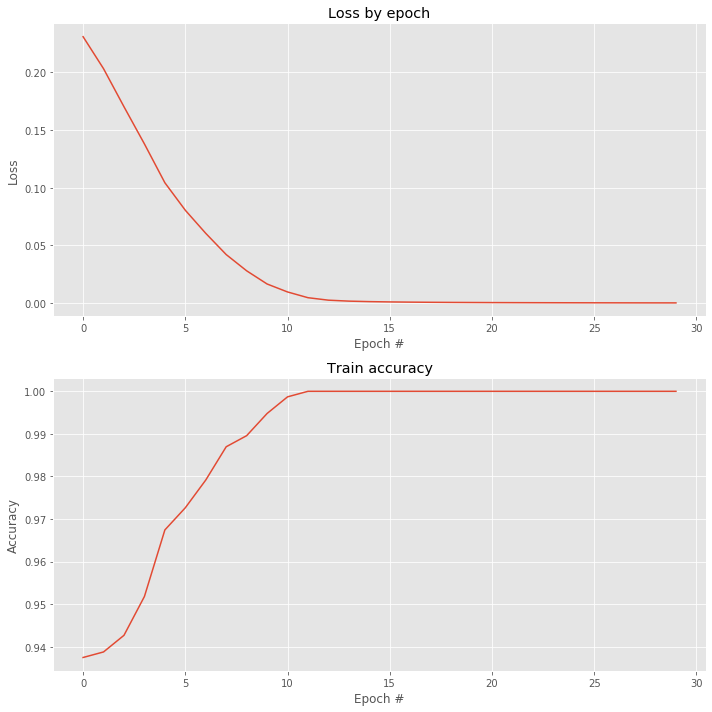

In [136]:
plot_nn_csv('plots/nn_1_est5.csv')

### Estrategia 5.2

    NORM - CLEAN - SVM(sigmoid)

In [137]:
print(f'------- SVM -------')
estrategy_5(x_train, x_val, x_test, 'svm')

------- SVM -------

Train Accuracy: 100.0
Val Accuracy: 93.75
Test Accuracy: 78.125



### Estrategia 5.3

    NORM - CLEAN - LinearSVM()

In [138]:
print(f'------- LinearSVM -------')
estrategy_5(x_train, x_val, x_test, 'linear_svm')

------- LinearSVM -------

Train Accuracy: 100.0
Val Accuracy: 87.5
Test Accuracy: 78.125



### Estrategia 5.4

    NORM - CLEAN - ADA

In [139]:
print(f'------- Ada -------')
estrategy_5(x_train, x_val, x_test, 'ada')

------- Ada -------

Train Accuracy: 87.5
Val Accuracy: 6.25
Test Accuracy: 18.75



### Estrategia 5.5

    NORM - CLEAN - KNN(3)


In [140]:
print(f'------- KNN(3) -------')
estrategy_5(x_train, x_val, x_test, 'knn')

------- KNN(3) -------

Train Accuracy: 75.0
Val Accuracy: 56.25
Test Accuracy: 46.875



## Dataset 2: 40 clases

In [141]:
DATASET_40 = datasets['dataset_40']

print(DATASET_40['x_train'].shape)

(120, 4349)


## Dataset 3: 100 clases

In [ ]:
DATASET_100 = datasets['dataset_100']

print(DATASET_100['x_train'].shape)

## Dataset 4: 166 clases

In [ ]:
DATASET_166 = datasets['dataset_166']

print(DATASET_166['x_train'].shape)

# BASE PARA PROBAR:

In [ ]:
# SVM
classifier = get_classifier('svm')
classifier.fit(x_train, y_train)

train_pred = classifier.predict(x_train)
test_pred = classifier.predict(x_test)

train_accuracy = accuracy_score(y_train, train_pred) * 100
test_accuracy = accuracy_score(y_test, test_pred) * 100

conf_matrix = confusion_matrix(y_test, test_pred)

print(f'\nTrain Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}\n')

print(conf_matrix)